In [18]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Lambda, concatenate, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
import keras.backend as K
import pandas as pd
import json
import pickle
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from models import AudioCNNModel, AudioLSTMModel, AudioCNNPopularityModel
import time

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from keras.models import load_model
from keras.models import model_from_json


In [2]:
np.random.seed()
num_frames = 599
num_freq_bins = 128
dummy_data = np.random.random((num_frames, num_freq_bins))
num_conv_filters_1 = 256
kernel_size = 4
num_genres = 18
embedding_dimension=300

In [3]:
with open("data/mfcc.npy", "rb") as f:
    mfcc_features = np.load(f)
with open("data/chroma.npy", "rb") as f:
    chroma_features = np.load(f)
with open("data/genre_onehot.npy", "rb") as f:
    y = np.load(f)
with open("data/embeddings.npy", "rb") as f:   
    embeddings = np.load(f)
with open("data/popularity.npy", "rb") as f:
    y_pop = np.load(f)

In [4]:
chromaTrain, chromaTest, mfccTrain, mfccTest, embeddingsTrain, embeddingsTest, yTrain, yTest, ypopTrain, ypopTest = train_test_split(chroma_features, mfcc_features, embeddings, y, y_pop, test_size = 0.2)

In [5]:
genre_mask = {}
for i in range(18):
    genre_mask[i] = []
for i in range(yTrain.shape[0]):
    genre_mask[yTrain[i].argmax()] += [i]

mfcc_new = []
chroma_new = []
embeddings_new = []
y_new = []
for i in range(18):
    if len(genre_mask[i]) <= 10:
        continue
    replace = True
    if len(genre_mask[i]) >= 1000:
        replace = False
    indices = np.random.choice(genre_mask[i], size=1000, replace=replace)
    if i == 1:
        indices = np.random.choice(genre_mask[i], size=4000, replace=replace)
    mfcc_new += [mfccTrain[indices]]
    chroma_new += [chromaTrain[indices]]
    embeddings_new += [embeddingsTrain[indices]]
    y_new += [yTrain[indices]]

mfccTrain = np.concatenate(mfcc_new)
chromaTrain = np.concatenate(chroma_new)
embeddingsTrain = np.concatenate(embeddings_new)
yTrain = np.concatenate(y_new)

In [6]:
indices = np.random.permutation(yTrain.shape[0])
mfccTrain = mfccTrain[indices]
chromaTrain = chromaTrain[indices]
embeddingsTrain = embeddingsTrain[indices]
yTrain = yTrain[indices]

In [44]:
#Hyperparams: Batch size, Learning rate, number of kernels
# batch_sizes = [10, 50, 100]
# learning_rate = [1e-2, 1e-3, 1e-4, 1e-5]
# num_conv_filters = [64, 128]
batch_sizes = [50]
learning_rate = [1e-5]
num_conv_filters = [128]

root_string = 'params/model_CNN_genre'
start_time = time.time()
for batch_size in batch_sizes:
    for lr in learning_rate:
        for num_filters in num_conv_filters:
            model_str = 'br' + str(batch_size) + 'lr' + str(lr) + 'filters' + str(num_filters)
            print(model_str)
            keras.backend.clear_session()
            model = AudioCNNModel(300, 12, num_filters, 4, kernel_size, num_genres, embedding_dimension, lambda1=0.01, lambda2=0.01)
            model.net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr), metrics=['accuracy'])
            history = model.net.fit([chromaTrain, mfccTrain, embeddingsTrain], yTrain, validation_split=0.3, epochs=20, batch_size=batch_size,verbose=0)            
            acc_dict[model_str] = history.history['acc']
            val_acc_dict[model_str] = history.history['val_acc']
            model_json = model.net.to_json()
            with open(root_string + model_str + '.json', "w") as f:
                f.write(model_json)
            model.net.save_weights(root_string + model_str + '.h5')
            print("time = ", time.time() - start_time)
            start_time = time.time()

br50lr1e-05filters128
time =  124.8515830039978


In [48]:
root_string = 'params/model_CNN_genre'

batch_sizes = [10, 50, 100]
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5]
num_conv_filters = [64, 128]

for batch_size in batch_sizes:
    for lr in learning_rate:
        for num_filters in num_conv_filters:
            precision = dict()
            recall = dict()
            average_precision = dict()
            n_classes = 18
            model_str = 'br' + str(batch_size) + 'lr' + str(lr) + 'filters' + str(num_filters)
            print(model_str)
            keras.backend.clear_session()
            with open(root_string + model_str + '.json','r') as f:
                m = f.read()
            model = model_from_json(m)
            model.load_weights(root_string + model_str + '.h5')
#             model = load_model(root_string + model_str + '.h5')
            ypred = model.predict([chromaTest, mfccTest, embeddingsTest])
            for i in range(n_classes):
                precision[i], recall[i], _ = precision_recall_curve(yTest[:, i],
                                                                    ypred[:, i])
                average_precision[i] = average_precision_score(yTest[:, i], ypred[:, i])

            # A "micro-average": quantifying score on all classes jointly
            precision["micro"], recall["micro"], _ = precision_recall_curve(yTest.ravel(),
                ypred.ravel())
            average_precision["micro"] = average_precision_score(yTest, ypred,
                                                                 average="micro")
            print('Average precision score, micro-averaged over all classes: {0:0.2f}'
                  .format(average_precision["micro"]))
            f1 = sklearn.metrics.f1_score(yTest.argmax(axis=1), ypred.argmax(axis=1), labels=np.arange(0,18,1), average='micro')
            print('F1 score: {0:0.2f}'.format(f1))
 

br10lr0.01filters64


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.06
F1 score: 0.01
br10lr0.01filters128
Average precision score, micro-averaged over all classes: 0.06
F1 score: 0.01
br10lr0.001filters64
Average precision score, micro-averaged over all classes: 0.48
F1 score: 0.51
br10lr0.001filters128
Average precision score, micro-averaged over all classes: 0.53
F1 score: 0.53
br10lr0.0001filters64
Average precision score, micro-averaged over all classes: 0.46
F1 score: 0.50
br10lr0.0001filters128
Average precision score, micro-averaged over all classes: 0.46
F1 score: 0.50
br10lr1e-05filters64
Average precision score, micro-averaged over all classes: 0.48
F1 score: 0.51
br10lr1e-05filters128
Average precision score, micro-averaged over all classes: 0.44
F1 score: 0.48
br50lr0.01filters64
Average precision score, micro-averaged over all classes: 0.05
F1 score: 0.02
br50lr0.01filters128
Average precision score, micro-averaged over all classes: 0.30
F1 score: 0.52
br50lr0.001filters64
Averag

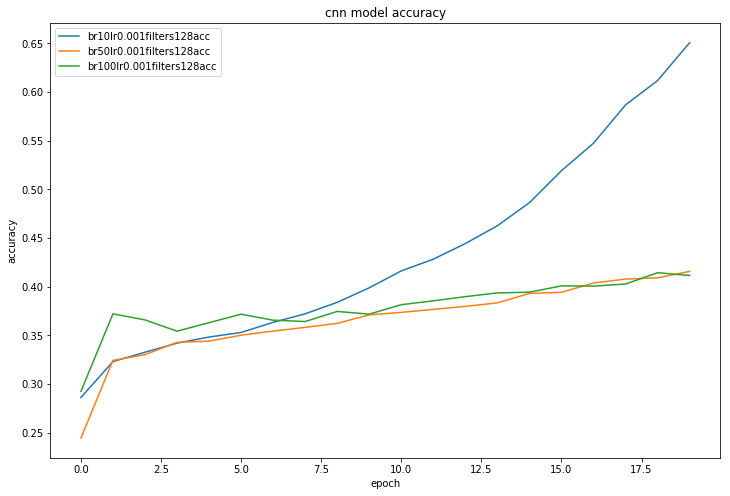

In [55]:
acc = acc_dict[model_str]
val_acc = val_acc_dict[model_str]       

plt.figure(figsize=(12,8))


for batch_size in batch_sizes:
    model_str = 'br' + str(batch_size) + 'lr' + str(1e-3) + 'filters' + str(128)
    acc = acc_dict[model_str]
    val_acc = val_acc_dict[model_str]   
    plt.plot(acc,label=model_str+'acc')
#     plt.plot(val_acc,label=model_str+'val_acc')
    

    
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()            
plt.show()

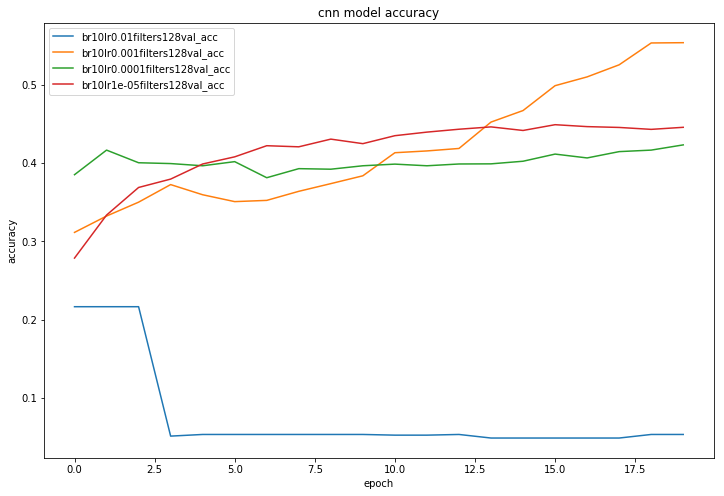

In [54]:
acc = acc_dict[model_str]
val_acc = val_acc_dict[model_str]       

plt.figure(figsize=(12,8))


for lr in learning_rate:
    model_str = 'br' + str(10) + 'lr' + str(lr) + 'filters' + str(128)
    acc = acc_dict[model_str]
    val_acc = val_acc_dict[model_str]   
#     plt.plot(acc,label=model_str+'acc')
    plt.plot(val_acc,label=model_str+'val_acc')

    
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()            
plt.show()

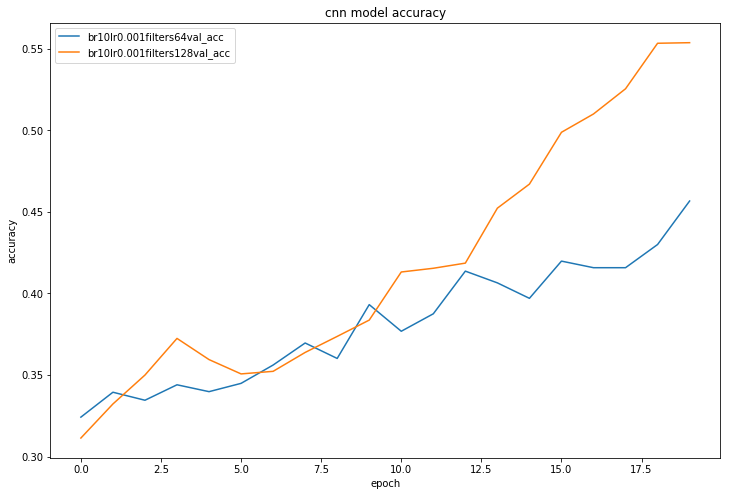

In [51]:
acc = acc_dict[model_str]
val_acc = val_acc_dict[model_str]       

plt.figure(figsize=(12,8))


for fil in num_conv_filters:
    model_str = 'br' + str(10) + 'lr' + str(1e-3) + 'filters' + str(fil)
    acc = acc_dict[model_str]
    val_acc = val_acc_dict[model_str]   
#     plt.plot(acc,label=model_str+'acc')
    plt.plot(val_acc,label=model_str+'val_acc')

    
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()            
plt.show()

In [57]:
with open('valacc.json', 'w') as fp:
    json.dump(val_acc_dict, fp)
with open('acc.json', 'w') as fp:
    json.dump(acc_dict, fp)

In [43]:
with open('valacc.json', 'r') as fp:
    val_acc_dict = json.load(fp)
with open('acc.json', 'r') as fp:
    acc_dict = json.load(fp)

In [56]:
acc_dict.keys()

dict_keys(['br10lr0.01filters64', 'br10lr0.01filters128', 'br10lr0.001filters64', 'br10lr0.001filters128', 'br10lr0.0001filters64', 'br10lr0.0001filters128', 'br10lr1e-05filters64', 'br10lr1e-05filters128', 'br50lr0.01filters64', 'br50lr0.01filters128', 'br50lr0.001filters64', 'br50lr0.001filters128', 'br50lr0.0001filters64', 'br50lr0.0001filters128', 'br50lr1e-05filters64', 'br100lr0.01filters64', 'br100lr0.01filters128', 'br100lr0.001filters64', 'br100lr0.001filters128', 'br100lr0.0001filters64', 'br100lr0.0001filters128', 'br100lr1e-05filters64', 'br100lr1e-05filters128', 'br50lr1e-05filters128'])

In [23]:
val_acc_dict

{'br10lr0.01filters64': [0.0512280710041523,
  0.04982456226359334,
  0.04982456226359334,
  0.2164912328777606,
  0.09771930008080967,
  0.05070175518069351,
  0.05070175518069351,
  0.05333333428491626,
  0.04947368509152479,
  0.05228070265106988,
  0.05333333428491626,
  0.05333333428491626,
  0.2164912328777606,
  0.04982456226359334,
  0.2157894783898404,
  0.2164912328777606,
  0.0512280710041523,
  0.050175439422590694,
  0.05228070265106988,
  0.05228070265106988],
 'br10lr0.01filters128': [0.2164912328777606,
  0.2164912328777606,
  0.2164912328777606,
  0.0512280710041523,
  0.05333333428491626,
  0.05333333428491626,
  0.05333333428491626,
  0.05333333428491626,
  0.05333333428491626,
  0.05333333428491626,
  0.05245614127631773,
  0.05245614127631773,
  0.05333333428491626,
  0.04877193064281815,
  0.04877193064281815,
  0.04877193064281815,
  0.04877193064281815,
  0.04877193064281815,
  0.05333333428491626,
  0.05333333428491626],
 'br10lr0.001filters64': [0.324210532519

In [40]:
with open('params/model_CNN_genrebr10lr0.01filters64.json', 'rb') as fp:
    m = fp.read()
model = model_from_json(m)

In [36]:
model_dict

{'class_name': 'Model',
 'config': {'name': 'model_3',
  'layers': [{'name': 'input_5',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 300, 12],
     'dtype': 'float32',
     'sparse': False,
     'name': 'input_5'},
    'inbound_nodes': []},
   {'name': 'input_4',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 300, 12],
     'dtype': 'float32',
     'sparse': False,
     'name': 'input_4'},
    'inbound_nodes': []},
   {'name': 'conv1d_10',
    'class_name': 'Conv1D',
    'config': {'name': 'conv1d_10',
     'trainable': True,
     'batch_input_shape': [None, 300, 12],
     'dtype': 'float32',
     'filters': 64,
     'kernel_size': [4],
     'strides': [1],
     'padding': 'valid',
     'data_format': 'channels_last',
     'dilation_rate': [1],
     'activation': 'linear',
     'use_bias': True,
     'kernel_initializer': {'class_name': 'VarianceScaling',
      'config': {'scale': 1.0,
       'mode': 'fan_avg',
       'distribut

In [37]:
model = model_from_json(model_dict)

TypeError: the JSON object must be str, bytes or bytearray, not 'dict'